# <font color=black> Fig 04b Brain and spinal cord functional connectivity </font>
<hr style="border:1px solid black">

### Imports

In [33]:
#-------- Basics
import sys,json,os, glob, re
import pandas as pd
import numpy as np

#------ load config file
main_dir='/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2025_brsc_aging_project/'
sys.path.append(main_dir+'/code/')
config_file=main_dir + '/config/analyses/brsc_functional.json'
with open(config_file) as config_f:
    config = json.load(config_f) # load config info
output_dir=config['project_dir'] + config["seed2seed"]['analysis_dir']['brain'] 


#-------- Plotting
#import seaborn as sns
#import statsmodels.api as sm
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from plotting import Plotting
plot=Plotting(config_file,output_dir)
colors_fc = ["#F2ECDF","#D5E5D7","#7BCEBC","#40BFAA","#04AF98","#029E89","#008C79"]  # green color map
fc_cmap = LinearSegmentedColormap.from_list("my_colormap", colors_fc) # create the custom fc cmap

#-------- Statistics
from brsc_statistics import Statistics 
from statsmodels.stats.multitest import multipletests
stat_func=Statistics(config=config,ana_dir="",analysis="")

#------- FC analyses
from connectivity.seed_to_target import Seed2target
seed2seed=Seed2target(config_file,IDs=config["participants_IDs_ALL"],kind="corr",seed_kind="atlas",structure=["brain"]) # initialize the function

%matplotlib inline
%load_ext autoreload
%autoreload 2


Your are going to run seed2seed analysis here:
/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project//figures/f02_functional_sc/preprint2025/seed2seed/brain/schaefer200_cobra/

Seeds are located within the brain structure

/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project//templates/MNI/atlas/schaefer200_cobra/schaefer200_cobra.txt
brain atlas info: schaefer200_cobra.txt


Start the analysis on: 67 participants
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<hr style="border:1px solid black">

### <font color=#04AF98> A Brain global functional connectivity 
#### <font color=#04AF98> A.1 Timeseries extraction

In [2]:
#timeseries_labels,labels_list=seed2seed.extract_atlas_data(rmv_col="remove",standardize='zscore',redo=True,n_jobs=3)
ts,timeseries_labels,labels_list=seed2seed.extract_atlas_data(standardize='zscore',redo=False,n_jobs=3)



The timeseries were already extracted, loading them ...


#### <font color=#04AF98> A.2 Correlation analysis

In [3]:
timeseries_zmean=[];labels_concat=[]; results = [];

#---- Correlation
corr_concat_df,corr_half_concat_df,corr_mean_df =seed2seed.correlation_df(timeseries_labels,
                                                                          timeseries_labels,
                                                                          labels_list=labels_list,
                                                                          tag= "_Schaefer200Cobra_z",
                                                                          groups=["ALL"],#,'YA','MA','OA'],
                                                         labels=True,
                                                      #partial_ts=timeseries_csf,
                                                         redo=False, n_jobs=6)


In [4]:

#---- Create sub df including sensorimotor region only
df_SomMot = corr_mean_df["ALL"][corr_mean_df["ALL"]['seed1'].str.contains("SomMot|Cerebellum|Subcortical") & corr_mean_df["ALL"]['seed2'].str.contains("SomMot|Cerebellum|Subcortical")].reset_index(drop=True)
df_half_SomMot=corr_half_concat_df["ALL"][corr_half_concat_df["ALL"]['seed1'].str.contains("SomMot|Cerebellum|Subcortical") & corr_half_concat_df["ALL"]['seed2'].str.contains("SomMot|Cerebellum|Subcortical")].reset_index(drop=True)

SomMot_list = [label for label in labels_list if re.search(r"SomMot|Cerebellum|Subcortical", label)]
networks_lat_list = [('L' if 'LH' in x.split('_')[0] else 'R') + ' ' + x.split('_')[1] for x in labels_list] # list of the 17 networks corresponding to each roi
networks_list = [x.split('_')[1] for x in labels_list] # list of the 17 networks corresponding to each roi

network_SomMot_list = [('L' if 'LH' in x.split('_')[0] else 'R') + ' ' + x.split('_')[1] for x in SomMot_list] # list of the R or L network name for each roi


#### <font color=#04AF98> A.3 Plot the sub-matrix (SomMot)

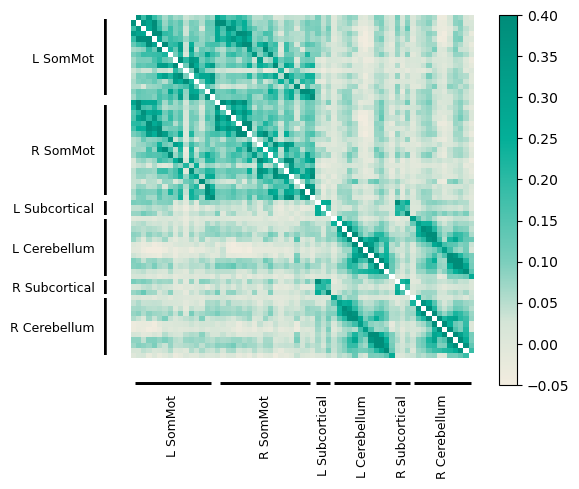

In [12]:
plot.plot_heatmap(matrix=df_SomMot,
                  networks=network_SomMot_list,
                      networks_y=network_SomMot_list,
                      vmax=0.4,vmin=-0.05,
                      cmap=fc_cmap,#half="upper",
                      index_raw='seed1',index_col='seed2',metric='fcorr',
                  xlabels=True,ylabels=True,
                       output_f=output_dir + '/figures/FC_matrix_brain.pdf',
                      save=False)
plt.show()

#### <font color=#04AF98> A.3 Intra vs Inter FC

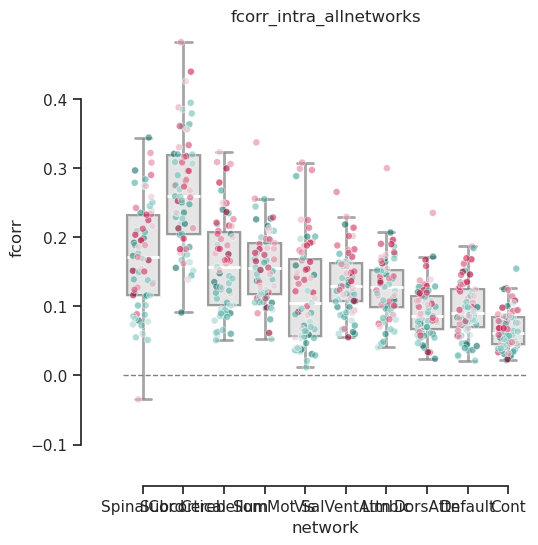

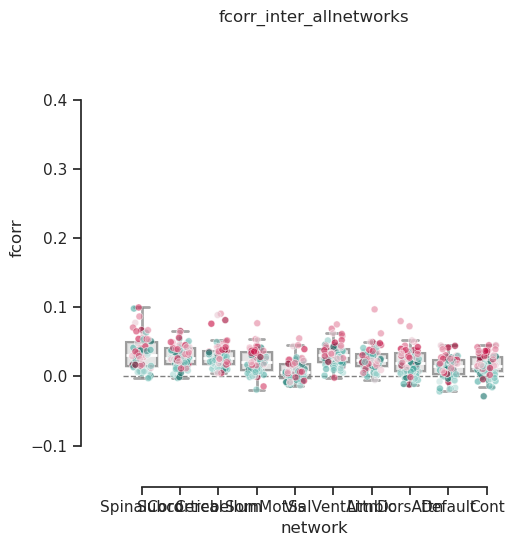

In [26]:
# Load spinal cord data
mean_betwith_sc = pd.read_csv(glob.glob(output_dir.split("brain")[0] + 'spinalcord/2_second_level/n67_betwith_fcorr.csv')[0])

# Plot params
colors = ["#0C675F","#3AA198","#68BCB4","#86C9C3","#C3E4E1","#F1C2CF","#E3849F","#D5476F","#C7093F","#850429"]  # blue → white → red
custom_cmap = LinearSegmentedColormap.from_list("my_colormap", colors)
limits={"intra":[-0.1,0.5],"inter":[-0.05,0.15]}

#----- Compute mean intra or inter network fcorr value and create the related df
mean_betwith_SomMot={};all_fcorr={}

for i in ["intra","inter"]:
    
    for net_nb, network in enumerate(np.append(np.unique(networks_list), "SpinalCord")):
        
        mean_network=corr_half_concat_df["ALL"][corr_half_concat_df["ALL"]['seed1'].str.contains(network) | corr_half_concat_df["ALL"]['seed2'].str.contains(network)].reset_index(drop=True)
        mean_betwith_SomMot[network] =mean_network.groupby(["IDs","age","sex","betwith_labels"], sort=False)[["fcorr"]].mean().reset_index()

        if network=="SpinalCord":
            mean_betwith_SomMot["SpinalCord"] = mean_betwith_sc.copy()
        mean_betwith_SomMot[network] =mean_betwith_SomMot[network][mean_betwith_SomMot[network]["betwith_labels"]==i]

        mean_betwith_SomMot[network]["network"]=network
            
        output_f=output_dir + '2_second_level/n67_'+network+'_betwith_fcorr.csv'
        if not os.path.exists(output_f):
            mean_betwith_SomMot[network].to_csv(output_f, index=False)

        if net_nb==0:
            all_fcorr[i]=mean_betwith_SomMot[network]
        else:
            all_fcorr[i]=pd.concat((all_fcorr[i],mean_betwith_SomMot[network]))


    plot.boxplots(df=all_fcorr[i],
                      x_data="network",x_order=['SpinalCord','Subcortical','Cerebellum','SomMot','Vis','SalVentAttn','Limbic','DorsAttn','Default',  'Cont'],
                          indiv_values=True,#invers_axes=True,
                          indiv_hue="age",indiv_color=custom_cmap,
                          palette=["gray","gray","gray","gray","gray","gray","gray","gray","gray","gray"],#output_dir=config['main_dir'] + config['analysis_dir']['spinalcord'] + '/figures/',
                          #output_tag='corr_' + group_name,
                      height=5,aspect=1,
                          y_data="fcorr",
                      ymin=limits["intra"][0], ymax=limits["intra"][1],
                      output_dir=output_dir + "/figures/",
                      output_tag="fcorr_"+i+"_allnetworks" ,plot_legend=False,
                      save=False)
    plt.show()

### Stats: intra vs inter

In [27]:
from scipy.stats import ttest_rel, wilcoxon, ttest_1samp


#--------- global statistics across networks
intra_mean = all_fcorr["intra"].groupby("IDs")["fcorr"].mean().rename("fcorr_intra")
inter_mean = all_fcorr["inter"].groupby("IDs")["fcorr"].mean().rename("fcorr_inter")
paired_df = pd.concat([intra_mean, inter_mean], axis=1).dropna()
t_stat, p_val = ttest_rel(paired_df["fcorr_intra"], paired_df["fcorr_inter"])
print("global results: " + str(np.round(t_stat,2)) + " "+ str(p_val))
print(str(np.round(np.mean(intra_mean),2)) + " "+ str(np.round(np.std(intra_mean),2)))
print(str(np.round(np.mean(inter_mean),2)) + " "+ str(np.round(np.std(inter_mean),2)))

#--------- statistics for each networks
merged = pd.merge(all_fcorr["intra"], all_fcorr["inter"], on=["IDs", "network"], suffixes=('_intra', '_inter'))

results = []
for network in merged["network"].unique():
    df_sub = merged[merged["network"] == network]
    t_stat, p_val = ttest_rel(df_sub["fcorr_intra"], df_sub["fcorr_inter"])
    results.append({"network": network,"mean_intra": df_sub["fcorr_intra"].mean(),"std_intra": df_sub["fcorr_intra"].std()
                    ,"mean_inter": df_sub["fcorr_inter"].mean(),"std_inter": df_sub["fcorr_inter"].std(),
        "t_stat": t_stat,"p_val": p_val})
print(" ")
print("results by networks")
results_df = pd.DataFrame(results)
print(results_df)


global results: 40.64 1.9544193902900426e-48
0.14 0.03
0.02 0.01
 
results by networks
       network  mean_intra  std_intra  mean_inter  std_inter     t_stat  \
0   Cerebellum    0.160529   0.068992    0.029959   0.018113  18.304501   
1         Cont    0.066644   0.028122    0.015842   0.015572  14.953790   
2      Default    0.095223   0.039555    0.013245   0.015469  16.624622   
3     DorsAttn    0.092130   0.036910    0.020528   0.018638  18.606561   
4       Limbic    0.127368   0.044694    0.024766   0.016523  21.312182   
5  SalVentAttn    0.133123   0.044484    0.031214   0.015452  20.782933   
6       SomMot    0.157635   0.051390    0.021879   0.016955  23.087580   
7  Subcortical    0.266182   0.080992    0.028833   0.015359  24.675585   
8          Vis    0.119183   0.074423    0.008628   0.014564  13.203048   
9   SpinalCord    0.173586   0.077321    0.033305   0.023930  17.250527   

          p_val  
0  1.470777e-27  
1  7.073451e-23  
2  2.765456e-25  
3  5.935356e-28

### Stats: intra or inter versus 0

In [28]:
#--------- global statistics across networks
t_stat, p_val = ttest_1samp(paired_df["fcorr_inter"], 0) 
print("global results: " + str(np.round(t_stat,2)) + " "+ str(p_val))

#--------- statistics for each networks
merged = pd.merge(all_fcorr["intra"], all_fcorr["inter"], on=["IDs", "network"], suffixes=('_intra', '_inter'))

results = []
for network in merged["network"].unique():
    df_sub = merged[merged["network"] == network]
    t_stat, p_val = ttest_1samp(df_sub["fcorr_inter"], 0)
    results.append({"network": network,"t_stat": t_stat,"p_val": p_val})
print(" ")
print("results by networks")
results_df = pd.DataFrame(results)
print(results_df)

global results: 14.8 1.1834660436818784e-22
 
results by networks
       network     t_stat         p_val
0   Cerebellum  13.538531  1.020047e-20
1         Cont   8.327056  6.882709e-12
2      Default   7.008233  1.566143e-09
3     DorsAttn   9.015393  4.083467e-13
4       Limbic  12.268801  1.096480e-18
5  SalVentAttn  16.534498  3.697004e-25
6       SomMot  10.562547  8.011207e-16
7  Subcortical  15.366021  1.744065e-23
8          Vis   4.849405  7.879289e-06
9   SpinalCord  11.392000  3.114434e-17


<hr style="border:1px solid black">

### <font color=#04AF98> B. Age-effect

/export02/data/tmp/ipykernel_396173/651953716.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results_df[roi] = pd.concat([all_results_df[roi], roi_results_df])
/export02/data/tmp/ipykernel_396173/651953716.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results_df[roi] = pd.concat([all_results_df[roi], roi_results_df])


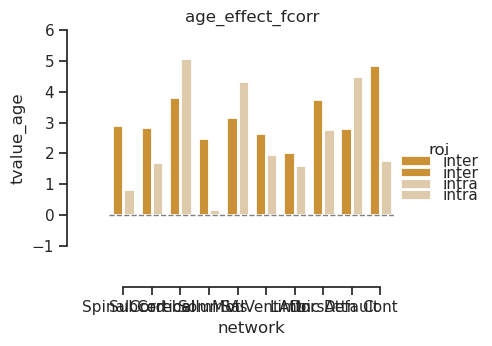

In [34]:

# Initialize result containers
roi_results = {}
all_results_df = {}

# Loop over 'intra' and 'inter' ROI pairs
all_betwith=pd.concat((all_fcorr["intra"],all_fcorr["inter"]),axis=0)
for roi_nb, roi in enumerate(["intra", "inter"]):
    all_results_df[roi] = pd.DataFrame(columns=[
        "network", "signed_r2", "p_age", "p_sex",
        "beta_age", "beta_sex", "tvalue_age", "tvalue_sex"
    ])
    
    roi_results[roi] = []

    # Analyze each network
    for net_nb, network in enumerate(np.append(np.unique(networks_list), "SpinalCord")):  #
        sub_df = all_betwith[all_betwith["network"]==network]
        sub_df = sub_df[sub_df["betwith_labels"] == roi].copy()

         # Compute statistics
        signed_r2, p_age, p_sex, beta_age, beta_sex, stat_age, stat_sex = stat_func.signed_partial_r2(
            df=sub_df, y="fcorr", predictor="age", covariates=["sex"]
        )

        result = {"network": network,"signed_r2": signed_r2,
                  "p_age": p_age,"p_sex": p_sex,
                  "beta_age": beta_age,"beta_sex": beta_sex,
                  "tvalue_age": stat_age,"tvalue_sex": stat_sex}

        roi_results[roi].append(result)

        #------- Plotting
        #plot.lmplots(
         #    df=sub_df,
          #  color=["grey"],hue_color_var="age",hue_palette=custom_cmap,
           #  x_data="age",y_data="fcorr",
            # xmin=15,xmax=85,
             #indiv_values=True,save=False)
   


        
    roi_results_df = pd.DataFrame(roi_results[roi])
    all_results_df[roi] = pd.concat([all_results_df[roi], roi_results_df])
    pvals = all_results_df[roi]["p_age"].values
    _, pvals_fdr, _, _ = multipletests(pvals, method='fdr_bh')
    all_results_df[roi]["p_age_fdr"]=pvals_fdr

# Add ROI type as a new column and concatenate
df_plot = pd.concat([
    df.assign(roi=roi_type) for roi_type, df in all_results_df.items()
])
df_plot = df_plot.sort_values(by=["network", "roi"])
color=["#E2971F","#e7cda4"]

plot.barplots(df=df_plot, x_data="network",x_order=['SpinalCord','Subcortical','Cerebellum','SomMot','Vis','SalVentAttn','Limbic','DorsAttn','Default',  'Cont'],
                  y_data="tvalue_age", hue="roi",
                  palette=color,
                  ymin=-1,ymax=6,indiv_values=False,
                output_dir=output_dir + "/figures/" ,
                  height=3,aspect=1,
                  output_tag="age_effect_fcorr",save=False)


In [35]:
all_results_df["inter"]

,network,signed_r2,p_age,p_sex,beta_age,beta_sex,tvalue_age,tvalue_sex,p_age_fdr
0,Cerebellum,0.183459,0.000284,0.162458,0.000452,-0.005686,3.840597,-1.413146,0.001259
1,Cont,0.257394,0.000008,0.027137,0.000460,-0.007308,4.869254,-2.261456,0.000077
2,Default,0.097991,0.006411,0.002755,0.000282,-0.010657,2.818599,-3.114588,0.009158
3,DorsAttn,0.164138,0.000378,0.004936,0.000440,-0.011666,3.754111,-2.912165,0.001259
4,Limbic,0.057521,0.044530,0.027094,0.000231,-0.008712,2.049366,-2.262106,0.044530
5,SalVentAttn,0.091705,0.009577,0.009604,0.000272,-0.009316,2.671058,-2.669980,0.011971
6,SomMot,0.082697,0.014850,0.017668,0.000284,-0.009446,2.503738,-2.435493,0.016500
7,Subcortical,0.110199,0.005762,0.144696,0.000297,-0.005248,2.857003,-1.476567,0.009158
8,Vis,0.123290,0.002215,0.004024,0.000298,-0.009532,3.188301,-2.984052,0.005539
9,SpinalCord,0.113481,0.004643,0.062206,0.000469,-0.010387,2.933827,-1.898012,0.009158


In [37]:
all_results_df["intra"]

,network,signed_r2,p_age,p_sex,beta_age,beta_sex,tvalue_age,tvalue_sex,p_age_fdr
0,Cerebellum,0.283144,0.000003,0.114828,0.002138,-0.022887,5.107213,-1.598634,0.000032
1,Cont,0.047808,0.077354,0.715024,0.000358,0.002502,1.795136,0.366739,0.128628
2,Default,0.239043,0.000028,0.448741,0.001126,0.006505,4.513026,0.762200,0.000140
3,DorsAttn,0.103438,0.006747,0.041266,0.000691,-0.017587,2.800095,-2.082850,0.016867
4,Limbic,0.039969,0.106862,0.584641,0.000520,-0.005978,1.635461,-0.549403,0.133577
5,SalVentAttn,0.057526,0.052396,0.967975,0.000621,0.000433,1.976627,0.040305,0.104793
6,SomMot,0.000534,0.853645,0.685429,0.000069,0.005198,0.185216,0.406914,0.853645
7,Subcortical,0.041215,0.090039,0.034599,0.000957,0.041079,1.721235,2.159081,0.128628
8,Vis,0.217304,0.000049,0.028277,0.002020,-0.035585,4.357944,-2.244320,0.000162
9,SpinalCord,0.009864,0.396002,0.003083,0.000447,-0.055059,0.854524,-3.076154,0.440003
